### Importing Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Reading the CSV file

In [4]:
housing_data = pd.read_csv('./Data Required for Projects/California_Housing.csv')
housing_data = housing_data.drop(['ocean_proximity'], axis=1)

In [5]:
housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200


### Exploratory Data Analysis

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

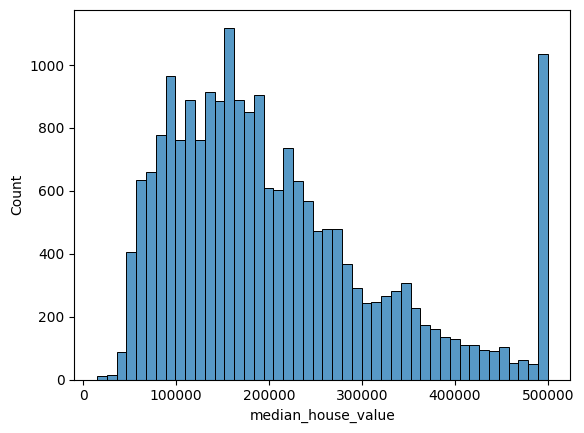

In [6]:
sns.histplot(housing_data['median_house_value'])

In [7]:
print(housing_data.isnull().sum())

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
dtype: int64


In [8]:
print(np.median(housing_data['population']))

1166.0


### Shuffling the indices of data

In [9]:
indexes = np.arange(len(housing_data))
indexes

array([    0,     1,     2, ..., 20637, 20638, 20639])

In [10]:
np.random.seed(42)
np.random.shuffle(indexes)

In [11]:
print(indexes)

[20046  3024 15663 ...  5390   860 15795]


### Splitting Data

In [12]:
n = len(housing_data)
eval_split = int(n*0.2)
test_split = int(n*0.2)
train_split = n - (eval_split+test_split)
print(train_split, eval_split, test_split)

12384 4128 4128


In [13]:
train_data = housing_data.iloc[indexes[:train_split]]
eval_data = housing_data.iloc[indexes[train_split:train_split+eval_split]]
test_data = housing_data.iloc[indexes[train_split+eval_split:]]
print(train_data.shape, eval_data.shape, test_data.shape)

(12384, 9) (4128, 9) (4128, 9)


In [14]:
X_train = train_data.drop('median_house_value', axis=1)
X_eval = eval_data.drop('median_house_value', axis=1)
X_test = test_data.drop('median_house_value', axis=1)
y_train = train_data['median_house_value']
y_eval = eval_data['median_house_value']
y_test = test_data['median_house_value']

In [15]:
print(X_train.shape, y_train.shape)
print(X_eval.shape, y_eval.shape)
print(X_test.shape, y_test.shape)

(12384, 8) (12384,)
(4128, 8) (4128,)
(4128, 8) (4128,)


In [16]:
y_train_values = np.log1p(train_data['median_house_value'].values)
y_eval_values = np.log1p(eval_data['median_house_value'].values)
y_test_values = np.log1p(test_data['median_house_value'].values)

### Avoiding Long Tail in the Histogram

<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

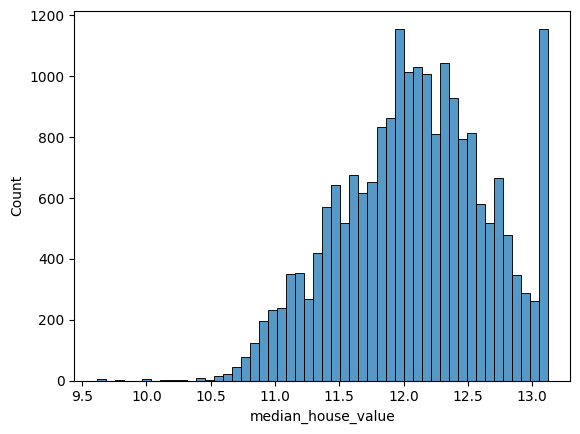

In [17]:
log_of_house_prices = np.log1p(housing_data['median_house_value'])
sns.histplot(log_of_house_prices, bins=50)

### Linear Regression

In [18]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [19]:
def prepare_X(df):
    df_num = df.fillna(0)
    X = df_num.values
    return X

In [20]:
X_train_set = prepare_X(X_train)
w0, w = train_linear_regression(X_train_set, y_train_values)

In [21]:
y_pred = w0 + X_train_set.dot(w)

### Metric - Root Mean Square Error (RMSE)

In [22]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [23]:
rmse(y_train_values, y_pred)

0.34131359101566766

In [24]:
X_eval_set = prepare_X(X_eval)
w0, w = train_linear_regression(X_eval_set, y_eval_values)
y_pred = w0 + X_eval_set.dot(w)
score1 = rmse(y_eval_values, y_pred)
print(score1)

0.32800729288516434


In [25]:
def prepare_X_mean_values(df):
    df_num = df.fillna(df['total_bedrooms'].mean())
    X = df_num.values
    return X

In [26]:
X_train_set_mean_approach = prepare_X_mean_values(X_train)
w0, w = train_linear_regression(X_train_set_mean_approach, y_train_values)
y_pred = w0 + X_train_set_mean_approach.dot(w)
rmse(y_train_values, y_pred)

0.3410416181032806

In [27]:
X_eval_set_mean_approach = prepare_X_mean_values(X_eval)
w0, w = train_linear_regression(X_eval_set_mean_approach, y_eval_values)
y_pred_2 = w0 + X_eval_set_mean_approach.dot(w)
score2 = rmse(y_eval_values, y_pred_2)
print(score2)

0.32800729288516434


In [28]:
print(round(score1, 2), round(score2, 2))

0.33 0.33


### Regularization

In [29]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg

    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [30]:
training_set = prepare_X(X_train)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(training_set, y_train_values, r=r)
    y_pred = w0 + training_set.dot(w)
    print(f"For r: {r:.6f}, rmse score is: {rmse(y_train_values, y_pred)}")

For r: 0.000001, rmse score is: 0.3413135910156898
For r: 0.000100, rmse score is: 0.34131359123782024
For r: 0.001000, rmse score is: 0.3413136131760799
For r: 0.010000, rmse score is: 0.34131575330229497
For r: 0.100000, rmse score is: 0.3414853062864339
For r: 1.000000, rmse score is: 0.3452327944054982
For r: 5.000000, rmse score is: 0.35016429871363136
For r: 10.000000, rmse score is: 0.3513878391350598


### Parameter Tuning (Picking up the best value)

In [31]:
evaluating_set = prepare_X(X_eval)

for r in [0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]:
    w0, w = train_linear_regression_reg(evaluating_set, y_eval_values, r=r)
    y_pred = w0 + evaluating_set.dot(w)
    print(f"For r: {r:.6f}, rmse score is: {round(rmse(y_eval_values, y_pred), 2)}")

For r: 0.000001, rmse score is: 0.33
For r: 0.000100, rmse score is: 0.33
For r: 0.001000, rmse score is: 0.33
For r: 0.010000, rmse score is: 0.33
For r: 0.100000, rmse score is: 0.33
For r: 1.000000, rmse score is: 0.34
For r: 5.000000, rmse score is: 0.34
For r: 10.000000, rmse score is: 0.34


In [32]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []
for s in seeds:

    indexes = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(indexes)
    
    train_data = housing_data.iloc[indexes[:train_split]]
    eval_data = housing_data.iloc[indexes[train_split:train_split+eval_split]]
    test_data = housing_data.iloc[indexes[train_split+eval_split:]]

    X_train = train_data.drop('median_house_value', axis=1)
    X_eval = eval_data.drop('median_house_value', axis=1)
    X_test = test_data.drop('median_house_value', axis=1)

    y_train = train_data['median_house_value']
    y_eval = eval_data['median_house_value']
    y_test = test_data['median_house_value']
    
    y_train_values = np.log1p(train_data['median_house_value'].values)
    y_eval_values = np.log1p(eval_data['median_house_value'].values)
    y_test_values = np.log1p(test_data['median_house_value'].values)

    evaluating_set = prepare_X(X_eval)
    w0, w = train_linear_regression(evaluating_set, y_eval_values)
    y_pred = w0 + evaluating_set.dot(w)
    print(f'For seed: {s}, rmse score is: {round(rmse(y_eval_values, y_pred), 3)}')
    rmse_scores.append(round(rmse(y_eval_values, y_pred), 3))

For seed: 0, rmse score is: 0.338
For seed: 1, rmse score is: 0.336
For seed: 2, rmse score is: 0.331
For seed: 3, rmse score is: 0.34
For seed: 4, rmse score is: 0.336
For seed: 5, rmse score is: 0.342
For seed: 6, rmse score is: 0.343
For seed: 7, rmse score is: 0.339
For seed: 8, rmse score is: 0.345
For seed: 9, rmse score is: 0.335


In [33]:
indexes = np.arange(n)
np.random.seed(9)
np.random.shuffle(indexes)
train_data = housing_data.iloc[indexes[:train_split]]
eval_data = housing_data.iloc[indexes[train_split:train_split+eval_split]]
test_data = housing_data.iloc[indexes[train_split+eval_split:]]

X_train = train_data.drop('median_house_value', axis=1)
X_eval = eval_data.drop('median_house_value', axis=1)
X_test = test_data.drop('median_house_value', axis=1)

y_train = train_data['median_house_value']
y_eval = eval_data['median_house_value']
y_test = test_data['median_house_value']

y_train_values = np.log1p(train_data['median_house_value'].values)
y_eval_values = np.log1p(eval_data['median_house_value'].values)
y_test_values = np.log1p(test_data['median_house_value'].values)

full_X_train = pd.concat([X_train, X_eval])
full_y_train = np.concatenate([y_train_values, y_eval_values])
full_training_X = prepare_X(full_X_train)
w0, w = train_linear_regression_reg(full_training_X, full_y_train, r=0.001)
y_pred = w0 + full_training_X.dot(w)
print(rmse(full_y_train, y_pred))

0.33977638801212


### Final RMSE Score

In [34]:
test_set = prepare_X(X_test)
w0, w = train_linear_regression_reg(test_set, y_test_values, r=0.001)
y_pred_final = w0 + test_set.dot(w)
print(rmse(y_test_values, y_pred_final))

0.34415219361264215
